# Analyze Cycles

In [72]:
using Revise
using Dates

dir = "cascade_20D_I1";

includet("./modules/OpticalCavity.jl")
includet("./modules/Thermodynamics.jl")
includet("./modules/Phaseonium.jl")
includet("./modules/BosonicOperators.jl")
includet("./modules/Measurements.jl")

includet("./src/main.jl")
config, ndims = init(dir)

NUM_CYCLES = 4

isochore_times = config["samplings"]["isochore"]
adiabatic_times = config["samplings"]["adiabatic"]
times = []
for j in 1:NUM_CYCLES
    for i in 1:isochore_times
        push!(times, "heating")
    end
    for i in 1:adiabatic_times
        push!(times, "expansion")
    end
    for i in 1:isochore_times
        push!(times, "cooling")
    end
    for i in 1:adiabatic_times
        push!(times, "compression")
    end
end

check_cutoff(state.ρ, ndims)

Simulation 5 - 20D - Fast thermalization - High entanglement: what happens to the efficiency?

Initial Temperature of the Cavity: 2.45
Apparent Temperature carried by Hot Phaseonium atoms: 200.00000000000253
Apparent Temperature carried by Cold Phaseonium atoms: 0.0
Average Photons: 0.38389790742424407
Last Element 1.8967849780359055e-11


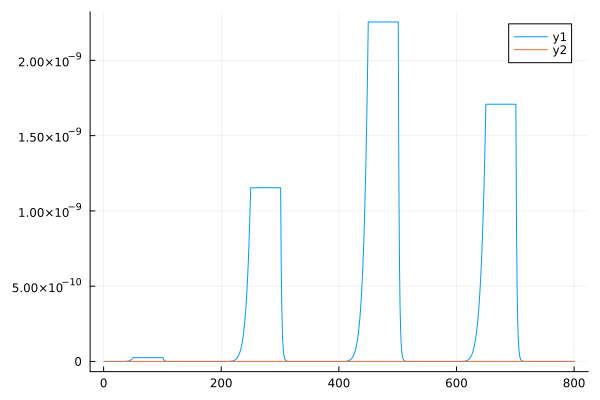

In [73]:
system_evolved = deserialize(dir * "/state_4C.jl");
system_evolution = deserialize(dir * "/state_evolution_4C.jl");

# Check that the last element is always negligible
ys = []
for (i, s) in enumerate(system_evolution)
    push!(ys,last(s))
end

plot(real(ys))
plot!(imag(ys))

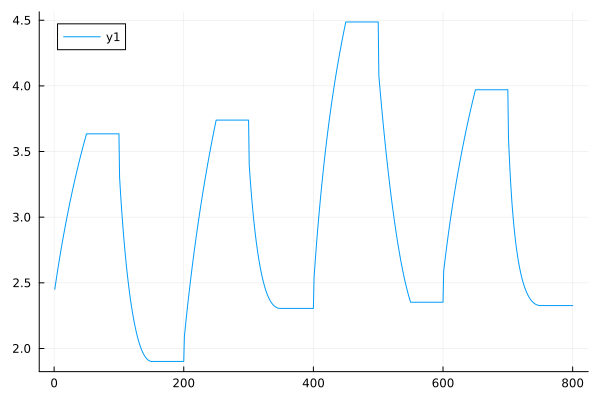

In [77]:
t = []
ω_heating = config["cavity"]["alpha"] / config["cavity"]["min_length"]
ω_cooling = config["cavity"]["alpha"] / config["cavity"]["max_length"]

ω_cycle = [i in ["heating", "expansion"] ? ω_heating : ω_cooling for i in times]
for (i, s) in enumerate(system_evolution)
    temp = Measurements.temperature(s, ω_cycle[i])
    push!(t, temp)
end

plot(real(t))

## Measure the Evolving Cascade State

## Entropy

In [ ]:
SA = [Measurements.entropy_vn(ρ) for ρ in state.ρ₁_evolution]
SB = [Measurements.entropy_vn(ρ) for ρ in state.ρ₂_evolution]

SAB = [Measurements.entropy_vn(ρ) for ρ in system_evolution];

In [ ]:
g = plot([SA, SB, SA+SB, SAB], label=[L"S_A" L"S_B" L"S_A+S_B" L"S_{AB}"], title="Entropy")
plot_strokes_overlays(g, SAB, isochore_samplings, adiabatic_samplings; x_max=total_cycles*total_cycle_time)

ArgumentError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [ ]:
# savefig(g, dir * "/entropy.png")
# savefig(g, dir * "/entropy.pdf")

### Mutual Information
Measure the correlation between the two cavities during the cycle

In [ ]:
I = SA + SB - SAB;

In [ ]:
println("Mutual Information goes down to: $(minimum(I))")
g = plot(I, label="Mutual Information", title="Mutual Information")
plot_strokes_overlays(g, I, isochore_samplings, adiabatic_samplings; x_max=total_cycles*total_cycle_time)

ArgumentError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [ ]:
# savefig(g, dir * "/mutual_info.png")
# savefig(g, dir * "/mutual_info.pdf")

### Heat
By Alicki definition
$$
Q = \text{Tr}\{\Delta\rho H(\omega)\} = \text{Tr}\{\rho_{n+1}H(\omega)\} - \text{Tr}\{\rho_{n}H(\omega)\} 
$$
Here heating and cooling happens with two different cavity lengths (two different $\omega$)

In [ ]:
ω₁_evolution = [α0 / l1 for l1 in state.c₁_evolution]
ω₂_evolution = [α0 / l2 for l2 in state.c₂_evolution]
# Expectation value of the Hamiltonians
energies_s₁ = [Measurements.avg_E(ρ, ω) for (ρ, ω) in zip(state.ρ₁_evolution, ω₁_evolution)]
energies_s₂ = [Measurements.avg_E(ρ, ω) for (ρ, ω) in zip(state.ρ₂_evolution, ω₂_evolution)]
# Heat absorbed and given
q₁ = [energies_s₁[i+1] - energies_s₁[i] for i in 1:length(energies_s₁)-1]
q₂ = [energies_s₂[i+1] - energies_s₂[i] for i in 1:length(energies_s₂)-1]

g_heat = plot(q₁+q₂, label=L"Q_{AB}", linewidth=2, linestyle=:dashdot)
plot!(q₁, label=L"Q_A")
plot!(q₂, label=L"Q_B")
plot_strokes_overlays(g_heat, q₁+q₂, isochore_samplings-2, adiabatic_samplings-1; x_max=total_cycle_time)

ArgumentError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

### Work
by Alicki definition
$$
W = \text{Tr}\{\rho\Delta H\} = \text{Tr}\{\rho H(\omega_{n+1})\} - \text{Tr}\{\rho H(\omega_n)\} 
$$
Here $\rho$ should always be the same (when written in the eigenbasis of its respective Hamiltonian.

In [ ]:
# Expectation value of the Hamiltonians
ρ = state.ρ₁_evolution[isochore_samplings + 1]
energies_s₁ = [Measurements.avg_E(ρ, ω) for ω in ω₁_evolution]
energies_s₂ = [Measurements.avg_E(ρ, ω) for ω in ω₂_evolution]
# Work done on the system and from it
w₁ = [energies_s₁[i+1] - energies_s₁[i] for i in 1:length(energies_s₁)-1]
w₂ = [energies_s₂[i+1] - energies_s₂[i] for i in 1:length(energies_s₂)-1]
net_w = sum(w₁+w₁)

g_work = plot(-w₁-w₂, label=L"W_{AB}", linewidth=2, linestyle=:dashdot)
plot!(-w₁, label=L"W_1")
plot!(-w₂, label=L"W_2")
plot!([0, total_cycle_time], [-net_w, -net_w], label="Total Work")
plot_strokes_overlays(g_work, -w₁-w₁, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

BoundsError: BoundsError: attempt to access 0-element Vector{Matrix{ComplexF64}} at index [51]

We can as well compute the work ``classically'' knowing the movement of the cavity wall and the force acting on it
$$
W = F \Delta l = p S \Delta l
$$

In [ ]:
identity_matrix = spdiagm(ones(NDIMS))
# Pressure Operator
function pressure_operator(ω, t, adiabatic_samplings, a, ad)
    t = t*adiabatic_samplings
    2 * a * ad  - a * a * exp(-2*im*ω*t) - ad * ad * exp(2*im*ω*t)
end
π₁_evolution = [pressure_operator(ω₁_evolution[i], i, adiabatic_samplings, a, ad)
    for i in 1:total_cycle_time]
π₂_evolution = [pressure_operator(ω₂_evolution[i], i, adiabatic_samplings, a, ad)
    for i in 1:total_cycle_time]
s1 = cavity1.surface
s2 = cavity2.surface
p1 = [Measurements.pressure(ρ, π₁, identity_matrix, α0, l, s1)
    for (ρ, π₁, l) in zip(state.ρ₁_evolution, π₁_evolution, state.c₁_evolution)]
p2 = [Measurements.pressure(ρ, π₂, identity_matrix, α0, l, s2)
    for (ρ, π₂, l) in zip(state.ρ₂_evolution, π₂_evolution, state.c₂_evolution)]

# Optomechanical Work
w₁ = [p*s1*(state.c₁_evolution[i+1]-state.c₁_evolution[i]) for (p, i) in zip(p1, 1:total_cycle_time-1)]
w₂ = [p*s2*(state.c₂_evolution[i+1]-state.c₂_evolution[i]) for (p, i) in zip(p2, 1:total_cycle_time-1)]
net_w = sum(w₁+w₂)
println("Net work: $net_w")

g_press = plot(w₁+w₂, label=L"W_{AB}")
plot!(w₁, label=L"W_{A}")
plot!(w₂, label=L"W_{B}")
plot!([0, total_cycle_time], [sum(w₁), sum(w₁)], label="Total Work")
plot_strokes_overlays(g_press, w₁+w₁, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

UndefVarError: UndefVarError: `NDIMS` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Efficiency
We can now compute efficiency as
$$
\eta = \frac{|W_\text{net}|}{Q_\text{in}}
$$

As a reference we can use Carnot Efficiency
$$
\eta_C = 1 - \frac{T_c}{T_h}
$$
or better the Curzon-Ahlborn Efficiency
$$
\eta_{CA} = 1 - \left(\frac{T_c}{T_h}\right)^{1/2}
$$

In [ ]:
# At what temperatures the machine operates?
temperatures_1 = [Measurements.temperature(ρ, ω) for (ρ, ω) in zip(state.ρ₁_evolution, ω₁_evolution)]
temperatures_2 = [Measurements.temperature(ρ, ω) for (ρ, ω) in zip(state.ρ₂_evolution, ω₂_evolution)]

T₁_hot = round(maximum(temperatures_1), digits=3)
T₁_cold = round(minimum(temperatures_1), digits=3)
println("Cavity A operates between the temperatures:\n $T₁_hot - $T₁_cold")
T₂_hot = round(maximum(temperatures_2), digits=3)
T₂_cold = round(minimum(temperatures_2), digits=3)
println("Cavity B operates between the temperatures:\n $T₂_hot - $T₂_cold")

T_cold_pred = - ω₁_evolution[end-adiabatic_samplings+2] / log(ga_c/gb_c)
T_hot_pred = - ω₁_evolution[1] / log(ga_h/gb_h)
# T_cold_pred = - ω₁_evolution[end] / log(ga_c/(1-ga_c/2))

ArgumentError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [ ]:
η₁C = round(1 - T₁_cold / T₁_hot, digits=3)
η₁CA = round(1 - sqrt(T₁_cold / T₁_hot), digits=3)
η₂C = round(1 - T₂_cold / T₂_hot, digits=3)
η₂CA = round(1 - sqrt(T₂_cold / T₂_hot), digits=3)
# Classic Efficiency (with classical temperatures)
T₁_hot_cl = round(classic_temp(T₁_hot, ω_max, ϕ_h), digits=3)
T₁_cold_cl = round(classic_temp(T₁_cold, ω_min, ϕ_c), digits=3)
T₂_hot_cl = round(classic_temp(T₂_hot, ω_max, ϕ_h), digits=3)
T₂_cold_cl = round(classic_temp(T₂_cold, ω_min, ϕ_c), digits=3)
η₁Cl = round(1 - T₁_cold_cl / T₁_hot_cl, digits=3)
η₂Cl = round(1 - T₂_cold_cl / T₂_hot_cl, digits=3)

net_w = abs(net_w)
q₁_in = sum(q₁[1:isochore_samplings])
net_w₁ = sum(w₁)
q₂_in = sum(q₂[1:isochore_samplings])
net_w₂ = sum(w₂)

η₁ = round(net_w₁ / q₁_in, digits=3)
η₂ = round(net_w₂ / q₂_in, digits=3)

string_out = """
    Cavity  | ηC \t| ηCA \t| η \t| ηCl \t| Tʰ \t| Tᶜ \t| TʰCl \t| TᶜCl
    A       | $η₁C\t| $η₁CA\t| $η₁\t| $η₁Cl\t| $T₁_hot\t| $T₁_cold\t| $T₁_hot_cl\t| $T₁_cold_cl
    B       | $η₂C\t| $η₂CA\t| $η₂\t| $η₂Cl\t| $T₂_hot\t| $T₂_cold\t| $T₂_hot_cl\t| $T₂_cold_cl
"""
println(string_out)

UndefVarError: UndefVarError: `T₁_cold` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
csv_out = replace(string_out, "|"=>",")
csv_out = replace(csv_out, "\t"=>"")
csv_out = replace(csv_out, " "=>"")

open(dir * "/results.csv", "w") do f
    write(f, csv_out)
end
;

UndefVarError: UndefVarError: `string_out` not defined in `Main`
Suggestion: check for spelling errors or missing imports.